In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

plt.rcParams['figure.figsize'] = [10, 4]

In [2]:
def init(N):
    x = np.random.uniform(size = N)
    y = np.random.uniform(size = N)

    return x, y


def get_dist(x, y, N):
    dist = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            dist[i][j] = calc_dist(x, y, i, j)

    return dist


def calc_dist(x, y, i, j):
    xij = x[i] - x[j]
    yij = y[i] - y[j]

    return np.sqrt(xij**2 + yij**2)


def calc_tot_dist(path, dist, N):
    sum = 0

    for i in path:
        sum += dist[i][(i + 1) % N]

    return sum


@jit(nopython=True)
def shuffle(path, dist, N):
    new_path = path.copy()
    indexes = np.random.choice(new_path, size = 2, replace = False)
    indexes.sort()
    start = indexes[0]
    end = indexes[1]

    for i in range(start, start + int(np.ceil((end - start) / 2))):
        aux = new_path[i]
        j = end + start - i
        new_path[i] = new_path[j]
        new_path[j] = aux

    start_prev = (start - 1)
    end_next = (end + 1) % N
    de = dist[new_path[end], new_path[end_next]] - dist[path[end], path[end_next]]\
       + dist[new_path[start_prev], new_path[start]] - dist[path[start_prev], path[start]]

    return new_path, de


@jit(nopython=True)
def mc_step(path, path_dist, temp, dist, N):
    new_path, de = shuffle(path, dist, N)

    r = np.random.rand()
    P = np.exp(-de / temp)

    # new path will always be accepted when de < 0
    # has a prob P of being accepted when de > 0
    if (r <= P):
        path = new_path
        path_dist = path_dist + de

    return path, path_dist


def plot_path(x, y, path, dist_over_time, title = ''):
    fig, axs = plt.subplots(1, 2)
    xs = [x[j] for j in path]
    ys = [y[j] for j in path]
    axs[0].plot(xs, ys, '-', marker='o')
    axs[0].set_title(title)

    axs[1].plot(dist_over_time)
    axs[1].set_title('Path distance over time')
    axs[1].set_xlabel('Number of iterations')

### Simulation Parameters

* N: number of cities
* samples: how many times the simulation will be executed
* temp_ini: initial "temperature"
* temp_f: final temperature
* dt: temperature decay rate

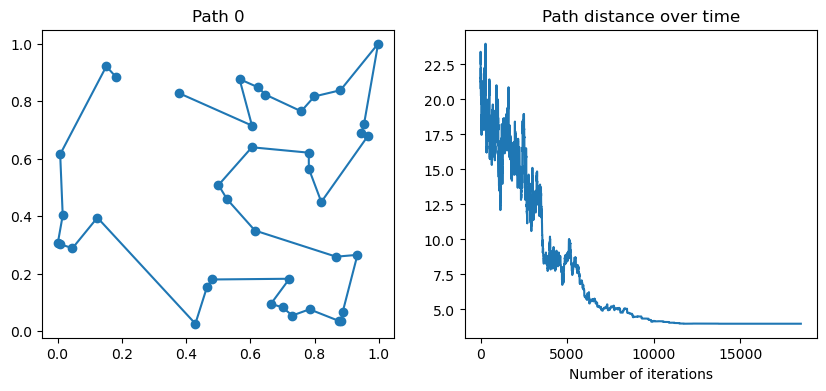

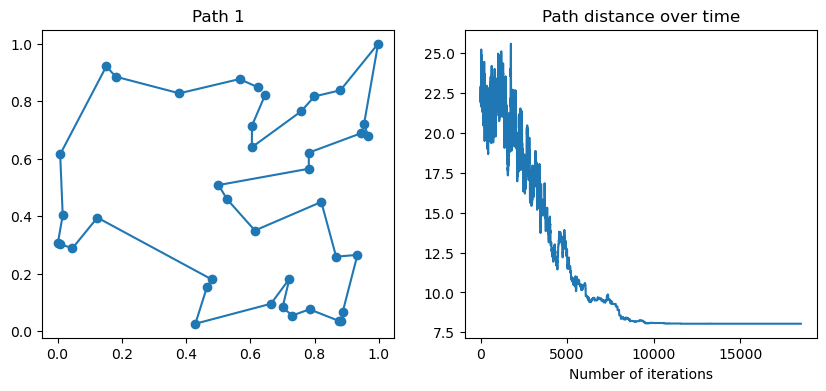

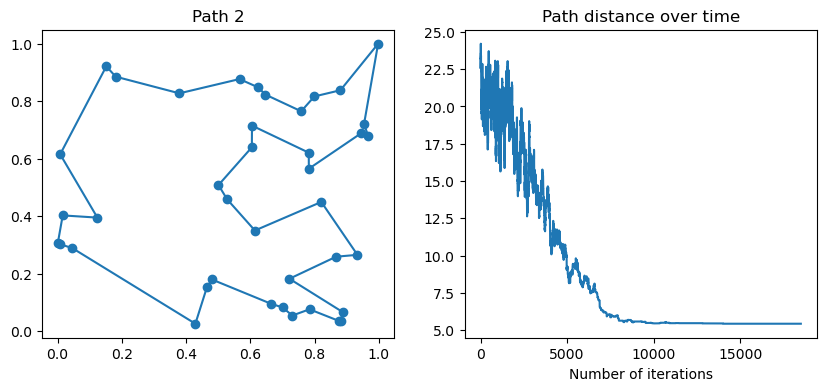

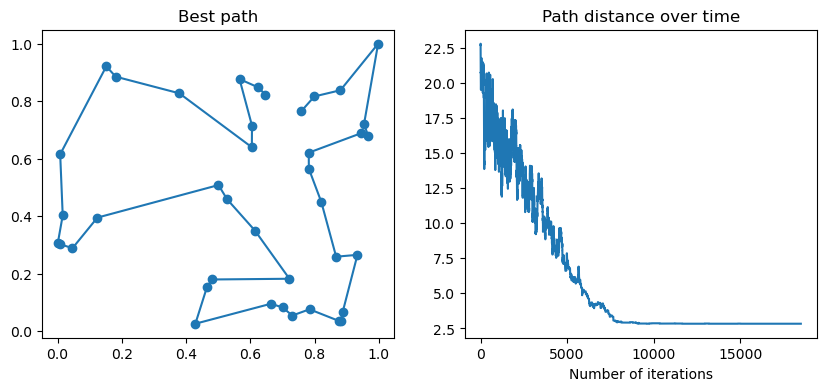

In [3]:
N = 40 # between 10 and 60
samples = 50 # between 10 and 50
temp_ini = 1# between 1 and 10
temp_f = 0.0003 # between 0.005 and 0.0001
dt = 0.8 # between 0.8 and 0.99

x, y = init(N)
dist = get_dist(x, y, N)

best_paths = []
best_dists = []
samples_dist_over_time = []

for i in range(samples):
    path = np.random.choice(N, size = N, replace = False)
    temp = temp_ini

    path_dist = best_dist = calc_tot_dist(path, dist, N)
    best_path = path

    iterations = 500

    dist_over_time = []

    # simulated annealing: start at high temp, reduce it slowly
    while temp > temp_f:
        # for each temp, iterate to find a good path
        for _ in range(iterations):
            path, path_dist = mc_step(path, path_dist, temp, dist, N)

            if (path_dist < best_dist):
                best_dist = path_dist
                best_path = path

            dist_over_time.append(path_dist)
        
        temp = temp * dt

    samples_dist_over_time.append(dist_over_time)
    best_paths.append(best_path)
    best_dists.append(best_dist)

# plot 3 of the best paths
for i in range(3):
    plot_path(x, y, best_paths[i], samples_dist_over_time[i], f"Path {i}")

# plot the best path found
best_i = np.argmin(best_dists)

plot_path(x, y, best_paths[best_i], samples_dist_over_time[best_i], "Best path")